<a href="https://colab.research.google.com/github/shatlykgurdov/3.1.2/blob/main/gwp2-msft-4challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# =========================
# GWP2 / FE610 - MSFT Monthly (2023-present)
# 4 Challenges in One Notebook:
# 1) Non-stationarity + spurious regression + proper modeling
# 2) Regime change detection
# 3) Multicollinearity (diagnose + mitigate)
# 4) Feature extraction
# =========================

# ---------- 0. INSTALLS (run if needed) ----------
# If you're on Google Colab, uncomment the next lines.
# !pip -q install yfinance statsmodels pandas numpy matplotlib scikit-learn scipy

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [14]:
# ---------- 1. LOAD & PREP DATA (MSFT monthly since 2023) ----------

ticker = "MSFT"
start_date = "2023-01-01"

df_d = yf.download(ticker, start=start_date, progress=False)  # daily
if df_d.empty:
    raise ValueError("No data downloaded. Check internet access or ticker symbol.")

# Convert to monthly (end-of-month)
df_m = df_d.resample("M").last().copy()

# Use Adjusted Close when available; else Close
price_col = "Adj Close" if "Adj Close" in df_m.columns else "Close"
df_m = df_m[[price_col, "Volume"]].rename(columns={price_col: "price"})
df_m["log_price"] = np.log(df_m["price"])

# Monthly log returns
df_m["log_ret"] = df_m["log_price"].diff()

df_m.head(), df_m.tail(), df_m.shape

(Price            price    Volume log_price   log_ret
 Ticker            MSFT      MSFT                    
 Date                                                
 2023-01-31  242.023453  26541100  5.489035       NaN
 2023-02-28  244.205963  22491000  5.498012  0.008977
 2023-03-31  282.273224  32766000  5.642875  0.144864
 2023-04-30  300.836853  36469600  5.706568  0.063693
 2023-05-31  322.228088  45950600  5.775260  0.068692,
 Price            price    Volume log_price   log_ret
 Ticker            MSFT      MSFT                    
 Date                                                
 2025-09-30  516.982422  19728200  6.248009  0.021979
 2025-10-31  516.842651  34006400  6.247738 -0.000270
 2025-11-30  492.010010  14386700  6.198499 -0.049239
 2025-12-31  483.619995  15601600  6.181299 -0.017200
 2026-01-31  472.940002  25539600  6.158969 -0.022331,
 (37, 4))

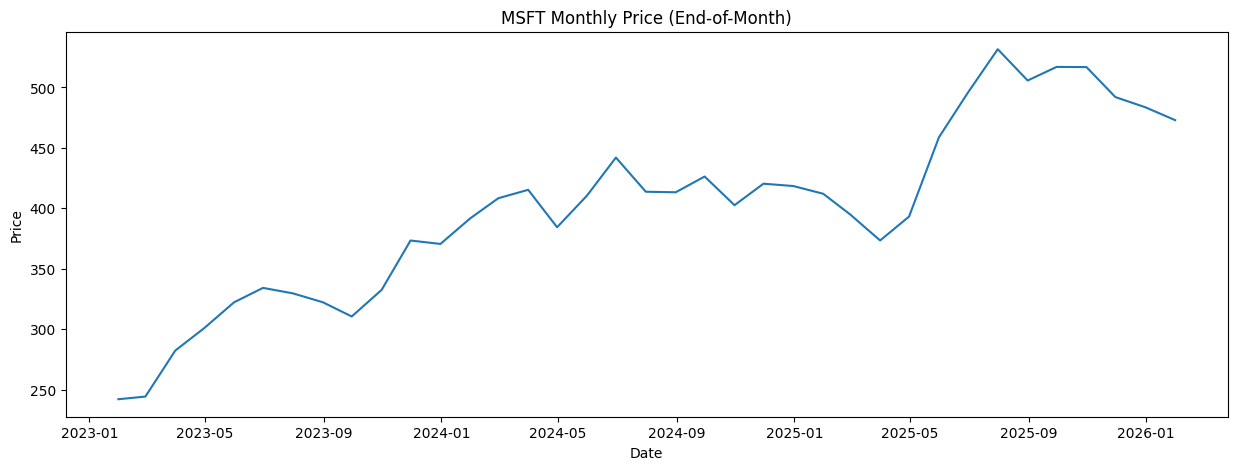

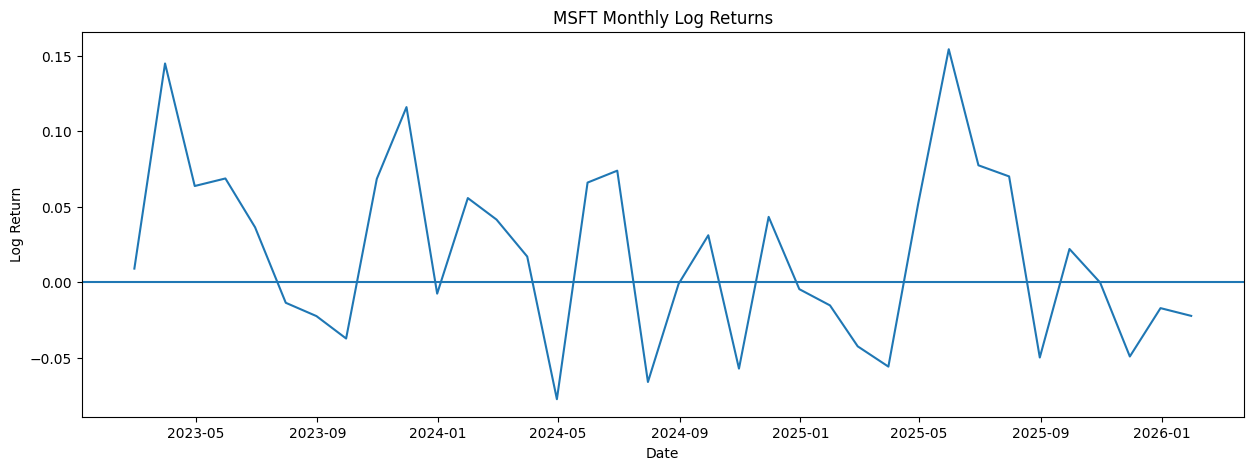

In [15]:
# ---------- 2. QUICK PLOTS ----------
plt.figure(figsize=(15, 5))
plt.plot(df_m.index, df_m["price"])
plt.title("MSFT Monthly Price (End-of-Month)")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(df_m.index, df_m["log_ret"])
plt.title("MSFT Monthly Log Returns")
plt.xlabel("Date"); plt.ylabel("Log Return")
plt.axhline(0)
plt.show()


✅ Challenge 1 — Non-stationarity (and NOT just unit root tests)

This section includes:

Unit root tests (ADF + KPSS)

Spurious regression demo

Proper modeling using differences

(Optional) Cointegration + ECM using market index (SPY)

In [16]:
# ---------- 3. HELPERS: ADF & KPSS ----------
def adf_test(series, name="series"):
    series = series.dropna()
    stat, pval, lags, nobs, crit, icbest = adfuller(series, autolag="AIC")
    return {
        "name": name,
        "ADF_stat": stat,
        "p_value": pval,
        "lags": lags,
        "nobs": nobs,
        "crit_1%": crit["1%"],
        "crit_5%": crit["5%"],
        "crit_10%": crit["10%"],
    }

def kpss_test(series, name="series", regression="c"):
    # regression="c" constant stationarity; "ct" trend-stationarity
    series = series.dropna()
    stat, pval, lags, crit = kpss(series, regression=regression, nlags="auto")
    return {
        "name": name,
        "KPSS_stat": stat,
        "p_value": pval,
        "lags": lags,
        "crit_10%": crit["10%"],
        "crit_5%": crit["5%"],
        "crit_2.5%": crit["2.5%"],
        "crit_1%": crit["1%"],
        "regression": regression
    }

# Run tests on log price and returns
results = []
results.append(adf_test(df_m["log_price"], "log_price"))
results.append(adf_test(df_m["log_ret"], "log_ret"))

results_k = []
results_k.append(kpss_test(df_m["log_price"], "log_price", regression="c"))
results_k.append(kpss_test(df_m["log_ret"], "log_ret", regression="c"))

pd.DataFrame(results), pd.DataFrame(results_k)

(        name  ADF_stat   p_value  lags  nobs   crit_1%   crit_5%  crit_10%
 0  log_price -2.499950  0.115486     0    36 -3.626652 -2.945951 -2.611671
 1    log_ret -4.660801  0.000100     0    35 -3.632743 -2.948510 -2.613017,
         name  KPSS_stat  p_value  lags  crit_10%  crit_5%  crit_2.5%  crit_1%  \
 0  log_price   0.757459     0.01     4     0.347    0.463      0.574    0.739   
 1    log_ret   0.252849     0.10     0     0.347    0.463      0.574    0.739   
 
   regression  
 0          c  
 1          c  )

In [17]:
# ---------- 4. SPURIOUS REGRESSION DEMO ----------
# Spurious regression: log_price ~ time trend (often shows high R^2 and "significant" slope)
tmp = df_m.dropna().copy()
tmp["t"] = np.arange(len(tmp))  # deterministic trend

X = sm.add_constant(tmp["t"])
y = tmp["log_price"]

model_spurious = sm.OLS(y, X).fit()
print(model_spurious.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     136.2
Date:                Sat, 03 Jan 2026   Prob (F-statistic):           1.95e-13
Time:                        11:22:43   Log-Likelihood:                 39.327
No. Observations:                  36   AIC:                            -74.65
Df Residuals:                      34   BIC:                            -71.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7100      0.027    209.412      0.0

In [18]:
# Check residual stationarity: if residuals are non-stationary, it's a spurious relationship
resid = model_spurious.resid

print("ADF on spurious regression residuals:")
print(pd.Series(adf_test(resid, "residuals")))

print("\nKPSS on spurious regression residuals (constant):")
print(pd.Series(kpss_test(resid, "residuals", regression="c")))

ADF on spurious regression residuals:
name        residuals
ADF_stat    -2.807423
p_value      0.057221
lags                1
nobs               34
crit_1%     -3.639224
crit_5%      -2.95123
crit_10%    -2.614447
dtype: object

KPSS on spurious regression residuals (constant):
name          residuals
KPSS_stat      0.115721
p_value             0.1
lags                  3
crit_10%          0.347
crit_5%           0.463
crit_2.5%         0.574
crit_1%           0.739
regression            c
dtype: object


In [19]:
# ---------- 5. PROPER MODELING: DIFFERENCE THE SERIES ----------
# Model log returns (stationary) as a function of something stationary/meaningful.
# Example: AR(1) model on returns (simple baseline)

tmp2 = df_m.dropna().copy()
tmp2["log_ret_lag1"] = tmp2["log_ret"].shift(1)

reg = tmp2.dropna()
X = sm.add_constant(reg["log_ret_lag1"])
y = reg["log_ret"]

model_ar1 = sm.OLS(y, X).fit()
print(model_ar1.summary())

# Diagnostics: residual autocorrelation
lb = acorr_ljungbox(model_ar1.resid, lags=[6], return_df=True)
print("\nLjung-Box test (lag 6):")
display(lb)

                            OLS Regression Results                            
Dep. Variable:                log_ret   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.344
Date:                Sat, 03 Jan 2026   Prob (F-statistic):              0.255
Time:                        11:23:10   Log-Likelihood:                 50.500
No. Observations:                  35   AIC:                            -97.00
Df Residuals:                      33   BIC:                            -93.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0149      0.011      1.421   

,lb_stat,lb_pvalue
6,2.556812,0.862056


In [23]:
# ---------- 6. OPTIONAL: COINTEGRATION + ECM (MSFT with SPY as market proxy) ----------

# 6.0 Safety checks
required_cols = ["price"]
for col in required_cols:
    if col not in df_m.columns:
        raise KeyError(f"df_m must contain '{col}'. Current columns: {df_m.columns}")

# Ensure log_price exists
if "log_price" not in df_m.columns:
    df_m = df_m.copy()
    df_m["log_price"] = np.log(df_m["price"])

# 6.1 Download SPY and convert to monthly
df_spy_d = yf.download("SPY", start=start_date, progress=False)
if df_spy_d.empty:
    raise ValueError("SPY data download failed (empty). Check internet access.")

df_spy_m = df_spy_d.resample("M").last().copy()
price_col_spy = "Adj Close" if "Adj Close" in df_spy_m.columns else "Close"

df_spy_m = df_spy_m[[price_col_spy]].rename(columns={price_col_spy: "spy_price"})
df_spy_m["spy_log_price"] = np.log(df_spy_m["spy_price"])

# 6.2 Join MSFT & SPY on the monthly index
combo = df_m.join(df_spy_m[["spy_log_price"]], how="inner").dropna()

# 6.3 Robust column flattening (handles tuples + slice(None) columns)
def flatten_weird_columns(cols):
    new_cols = []
    for c in cols:
        if isinstance(c, tuple):
            # e.g., ('price','MSFT') or ('log_price','')
            a = c[0]
            b = c[1] if len(c) > 1 else ""
            if b == "" or b is None:
                new_cols.append(str(a))
            else:
                new_cols.append(f"{a}_{b}")
        elif isinstance(c, slice):
            # pandas may insert slice(None, None, None) for aligned single-level column
            new_cols.append("spy_log_price")
        else:
            new_cols.append(str(c))

    # Ensure unique names (avoid collisions)
    out = []
    seen = {}
    for name in new_cols:
        if name not in seen:
            seen[name] = 0
            out.append(name)
        else:
            seen[name] += 1
            out.append(f"{name}_{seen[name]}")
    return out

combo = combo.copy()
combo.columns = flatten_weird_columns(combo.columns)

print("combo columns:", combo.columns.tolist())
print("combo shape:", combo.shape)

# 6.4 Detect correct MSFT log price column name (in case it becomes log_price_MSFT)
msft_log_candidates = [c for c in combo.columns if c in ["log_price", "log_price_MSFT", "log_price_msft"]]
if not msft_log_candidates:
    # fallback: search columns containing 'log_price'
    msft_log_candidates = [c for c in combo.columns if "log_price" in c.lower() and "spy" not in c.lower()]

if not msft_log_candidates:
    raise KeyError(f"Could not find MSFT log price column after flattening. Columns: {combo.columns.tolist()}")

msft_log_col = msft_log_candidates[0]

# Ensure SPY log price exists
if "spy_log_price" not in combo.columns:
    # fallback: search for it
    spy_candidates = [c for c in combo.columns if "spy_log_price" in c.lower()]
    if not spy_candidates:
        raise KeyError(f"Could not find 'spy_log_price' after flattening. Columns: {combo.columns.tolist()}")
    spy_log_col = spy_candidates[0]
else:
    spy_log_col = "spy_log_price"

print(f"Using MSFT log column: {msft_log_col}")
print(f"Using SPY log column:  {spy_log_col}")

# 6.5 Cointegration test
score, pvalue, _ = coint(combo[msft_log_col], combo[spy_log_col])
print(f"Cointegration test (MSFT vs SPY): score={score:.4f}, p-value={pvalue:.4f}")

# 6.6 Long-run equilibrium regression: log(MSFT) = a + b*log(SPY) + u
X_lr = sm.add_constant(combo[spy_log_col])
y_lr = combo[msft_log_col]
lr = sm.OLS(y_lr, X_lr).fit()

combo["ec_term"] = lr.resid

# 6.7 ECM: Δlog(MSFT) = α + β*Δlog(SPY) + γ*EC_{t-1} + ε
combo["d_log_msft"] = combo[msft_log_col].diff()
combo["d_log_spy"] = combo[spy_log_col].diff()
combo["ec_lag1"] = combo["ec_term"].shift(1)

ecm_df = combo.dropna().copy()
X_ecm = sm.add_constant(ecm_df[["d_log_spy", "ec_lag1"]])
y_ecm = ecm_df["d_log_msft"]

ecm = sm.OLS(y_ecm, X_ecm).fit()

print("\nLong-run regression summary:")
print(lr.summary())

print("\nECM regression summary:")
print(ecm.summary())

combo columns: ['price_MSFT', 'Volume_MSFT', 'log_price', 'log_ret', 'spy_log_price']
combo shape: (36, 5)
Using MSFT log column: log_price
Using SPY log column:  spy_log_price
Cointegration test (MSFT vs SPY): score=-3.0309, p-value=0.1030

Long-run regression summary:
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     205.3
Date:                Sat, 03 Jan 2026   Prob (F-statistic):           5.70e-16
Time:                        11:27:12   Log-Likelihood:                 45.468
No. Observations:                  36   AIC:                            -86.94
Df Residuals:                      34   BIC:                            -83.77
Df Model:                           1                                         
Covariance Type:  

✅ Challenge 2 — Regime change detection

We’ll detect regimes in returns volatility using:

rolling volatility plot

a simple variance break test (split sample)

optional “unknown break date” scan (choose break that maximizes variance difference)

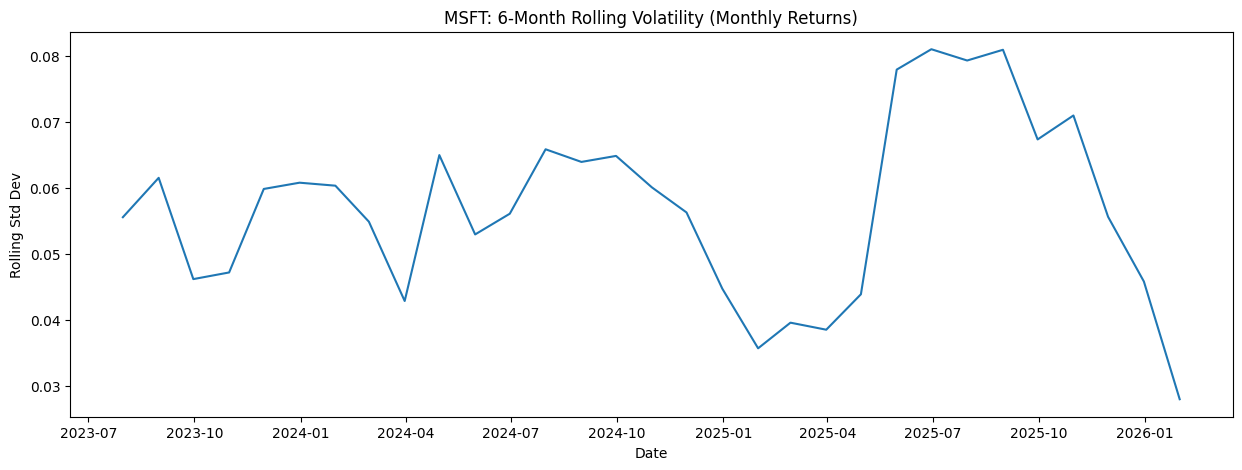

In [25]:
# ---------- 7. REGIME CHANGE: ROLLING VOLATILITY ----------
tmp = df_m.dropna().copy()
tmp["roll_vol_6"] = tmp["log_ret"].rolling(6).std()  # 6-month rolling vol

plt.figure(figsize=(15, 5))
plt.plot(tmp.index, tmp["roll_vol_6"])
plt.title("MSFT: 6-Month Rolling Volatility (Monthly Returns)")
plt.xlabel("Date"); plt.ylabel("Rolling Std Dev")
plt.show()

In [26]:
# ---------- 8. SIMPLE BREAK TEST: BEFORE vs AFTER a candidate event ----------
# Choose a candidate break date (you can change this to something meaningful).
break_date = "2024-01-31"

before = tmp.loc[tmp.index <= break_date, "log_ret"].dropna()
after  = tmp.loc[tmp.index > break_date, "log_ret"].dropna()

print("Sample sizes:", len(before), len(after))
print("Before vol:", before.std(), "After vol:", after.std())

# F-test for equality of variances (approx, assumes normality)
from scipy.stats import f

if len(before) > 3 and len(after) > 3:
    s1, s2 = before.var(ddof=1), after.var(ddof=1)
    F = s1/s2 if s1 >= s2 else s2/s1
    dfn, dfd = (len(before)-1, len(after)-1)
    p = 2*min(f.cdf(F, dfn, dfd), 1-f.cdf(F, dfn, dfd))  # two-sided
    print(f"Variance F-test: F={F:.4f}, p-value={p:.4f}")
else:
    print("Not enough points to run variance test.")

Sample sizes: 12 24
Before vol: 0.05657560382914903 After vol: 0.05732832522410383
Variance F-test: F=1.0268, p-value=0.9110


In [27]:
# ---------- 9. OPTIONAL: SCAN FOR BREAK DATE (maximize variance ratio) ----------
# This finds a break that makes volatility differ most (simple heuristic).
rets = tmp["log_ret"].dropna()
dates = rets.index

min_seg = 6  # minimum segment length (months)
candidates = dates[min_seg:-min_seg]

best = None
for d in candidates:
    b = rets.loc[rets.index <= d]
    a = rets.loc[rets.index > d]
    if len(b) < min_seg or len(a) < min_seg:
        continue
    ratio = max(b.var(ddof=1), a.var(ddof=1)) / min(b.var(ddof=1), a.var(ddof=1))
    if (best is None) or (ratio > best["ratio"]):
        best = {"break_date": d, "ratio": ratio, "n_before": len(b), "n_after": len(a)}

best

{'break_date': Timestamp('2025-07-31 00:00:00'),
 'ratio': 4.615958349285892,
 'n_before': 30,
 'n_after': 6}

✅ Challenge 3 — Multicollinearity

We’ll create correlated predictors from MSFT (moving averages, momentum, etc.), then:

run correlation matrix

compute VIF

show mitigation via PCA / dropping variables

In [28]:
# ---------- 10. BUILD PREDICTORS (intentionally correlated) ----------
d = df_m.copy()

# Moving averages on price (very correlated)
d["ma_3"] = d["price"].rolling(3).mean()
d["ma_6"] = d["price"].rolling(6).mean()
d["ma_12"] = d["price"].rolling(12).mean()

# Momentum features (also correlated with MAs)
d["mom_3"] = d["price"].pct_change(3)
d["mom_6"] = d["price"].pct_change(6)

# Target: next-month return (prediction style)
d["y_next_ret"] = d["log_ret"].shift(-1)

mc = d.dropna().copy()
features = ["ma_3", "ma_6", "ma_12", "mom_3", "mom_6", "Volume"]
X = mc[features]
y = mc["y_next_ret"]

# Correlation matrix
corr = X.corr()
corr


,Price,ma_3,ma_6,ma_12,mom_3,mom_6,Volume
,Ticker,,,,,,MSFT
Price,Ticker,,,,,,
ma_3,,1.000000,0.922887,0.807617,0.037804,0.408801,-0.222131
ma_6,,0.922887,1.000000,0.919661,-0.263829,0.107851,-0.283893
ma_12,,0.807617,0.919661,1.000000,-0.253095,-0.100042,-0.216469
mom_3,,0.037804,-0.263829,-0.253095,1.000000,0.544612,0.230265
mom_6,,0.408801,0.107851,-0.100042,0.544612,1.000000,0.063170
Volume,MSFT,-0.222131,-0.283893,-0.216469,0.230265,0.063170,1.000000


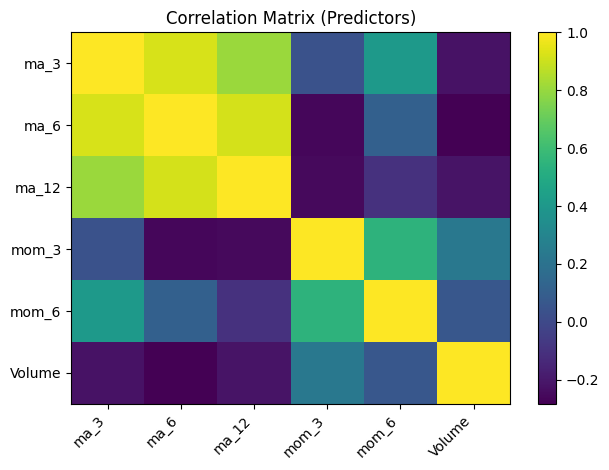

In [29]:
plt.figure()
plt.imshow(corr, aspect="auto")
plt.title("Correlation Matrix (Predictors)")
plt.xticks(range(len(features)), features, rotation=45, ha="right")
plt.yticks(range(len(features)), features)
plt.colorbar()
plt.tight_layout()
plt.show()

In [30]:
# ---------- 11. VIF COMPUTATION ----------
X_const = sm.add_constant(X)
vif = []
for i in range(X_const.shape[1]):
    vif.append({
        "variable": X_const.columns[i],
        "VIF": variance_inflation_factor(X_const.values, i)
    })

pd.DataFrame(vif).sort_values("VIF", ascending=False)

,variable,VIF
0,const,138.033582
2,"(ma_6, )",36.268726
1,"(ma_3, )",29.471936
3,"(ma_12, )",10.767009
5,"(mom_6, )",4.063702
4,"(mom_3, )",2.807318
6,"(Volume, MSFT)",1.150065


In [31]:
# ---------- 12. SHOW IMPACT: OLS with multicollinear predictors ----------
model_mc = sm.OLS(y, X_const).fit()
print(model_mc.summary())

                            OLS Regression Results                            
Dep. Variable:             y_next_ret   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                 -0.070
Method:                 Least Squares   F-statistic:                    0.7386
Date:                Sat, 03 Jan 2026   Prob (F-statistic):              0.626
Time:                        11:32:00   Log-Likelihood:                 39.436
No. Observations:                  25   AIC:                            -64.87
Df Residuals:                      18   BIC:                            -56.34
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1034      0

In [32]:
# ---------- 13. MITIGATION OPTION A: DROP REDUNDANT VARIABLES ----------
# Example: keep only one moving average instead of three
X_drop = mc[["ma_6", "mom_3", "Volume"]]
X_drop_const = sm.add_constant(X_drop)
model_drop = sm.OLS(y, X_drop_const).fit()
print(model_drop.summary())

                            OLS Regression Results                            
Dep. Variable:             y_next_ret   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.182
Date:                Sat, 03 Jan 2026   Prob (F-statistic):              0.340
Time:                        11:32:15   Log-Likelihood:                 38.635
No. Observations:                  25   AIC:                            -69.27
Df Residuals:                      21   BIC:                            -64.39
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1408      0

In [33]:
# ---------- 14. MITIGATION OPTION B: PCA FEATURES ----------
# PCA converts correlated predictors into uncorrelated components.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
Z = pca.fit_transform(X_scaled)

Z_df = pd.DataFrame(Z, index=X.index, columns=["PC1", "PC2"])
Z_const = sm.add_constant(Z_df)

model_pca = sm.OLS(y.loc[Z_df.index], Z_const).fit()
print(model_pca.summary())

print("\nExplained variance ratio:", pca.explained_variance_ratio_)

                            OLS Regression Results                            
Dep. Variable:             y_next_ret   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.569
Date:                Sat, 03 Jan 2026   Prob (F-statistic):              0.231
Time:                        11:32:32   Log-Likelihood:                 38.352
No. Observations:                  25   AIC:                            -70.70
Df Residuals:                      22   BIC:                            -67.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0098      0.011      0.878      0.3

✅ Challenge 4 — Feature extraction

We’ll build features from raw price/volume and show:

extracted feature set

how they retain key information (trend, momentum, volatility)

In [34]:
# ---------- 15. FEATURE EXTRACTION ----------
fx = df_m.copy()

# Core transformations
fx["ret"] = fx["price"].pct_change()
fx["log_ret"] = fx["log_price"].diff()

# Trend / momentum
fx["mom_1"] = fx["price"].pct_change(1)
fx["mom_3"] = fx["price"].pct_change(3)
fx["mom_6"] = fx["price"].pct_change(6)

# Volatility (rolling)
fx["vol_3"] = fx["log_ret"].rolling(3).std()
fx["vol_6"] = fx["log_ret"].rolling(6).std()

# Moving average ratios (normalize trend)
fx["ma_3"] = fx["price"].rolling(3).mean()
fx["ma_6"] = fx["price"].rolling(6).mean()
fx["ma_ratio_3_6"] = fx["ma_3"] / fx["ma_6"]

# Volume features
fx["vol_chg"] = fx["Volume"].pct_change()

# Final feature set
feature_cols = ["mom_1", "mom_3", "mom_6", "vol_3", "vol_6", "ma_ratio_3_6", "vol_chg"]
feat = fx[feature_cols].dropna()

feat.head(), feat.describe()

(Price          mom_1     mom_3     mom_6     vol_3     vol_6 ma_ratio_3_6  \
 Ticker                                                                      
 Date                                                                        
 2023-07-31 -0.013567  0.095666  0.361921  0.041489  0.055579     1.087508   
 2023-08-31 -0.022226  0.000195  0.319750  0.031715  0.061552     1.042677   
 2023-09-30 -0.036643 -0.070833  0.099931  0.011963  0.046192     1.002695   
 2023-10-31  0.070815  0.008650  0.105144  0.057251  0.047200     0.989363   
 2023-11-30  0.122946  0.158406  0.158631  0.078464  0.059865     1.015100   
 
 Price        vol_chg  
 Ticker                
 Date                  
 2023-07-31 -0.051683  
 2023-08-31  0.037923  
 2023-09-30 -0.085710  
 2023-10-31 -0.160763  
 2023-11-30  0.507720  ,
 Price       mom_1      mom_3      mom_6      vol_3      vol_6 ma_ratio_3_6  \
 Ticker                                                                       
 count   31.000000  31.

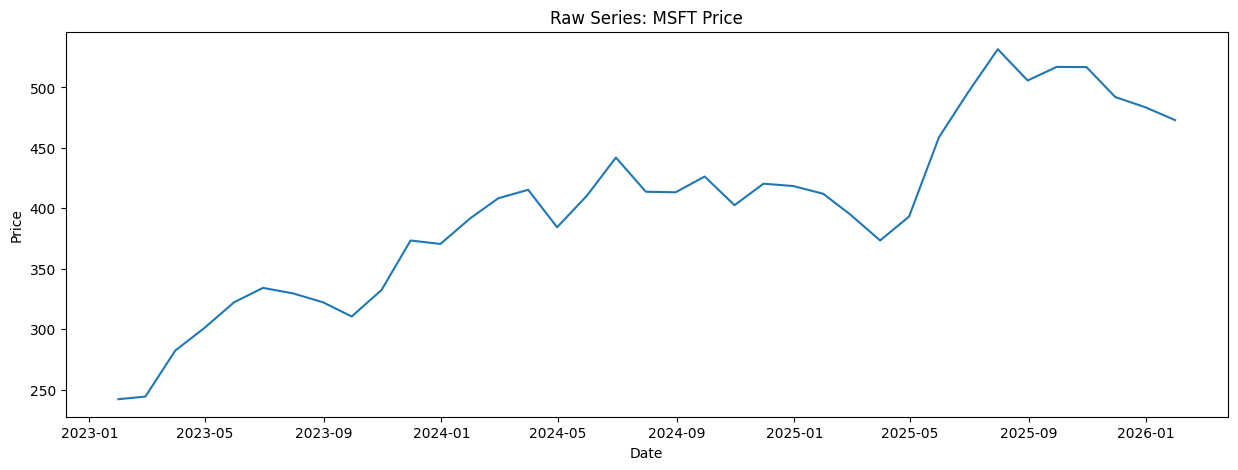

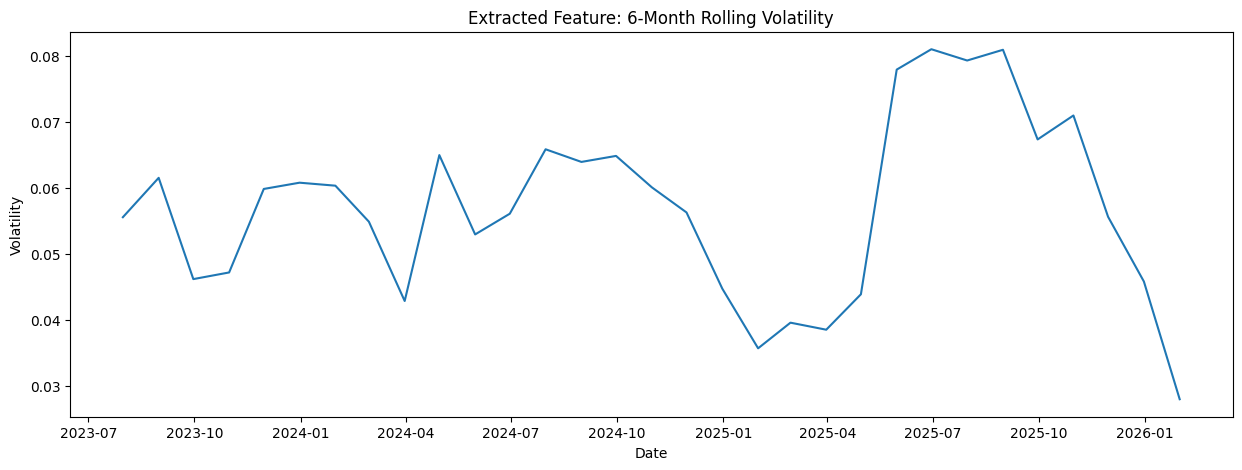

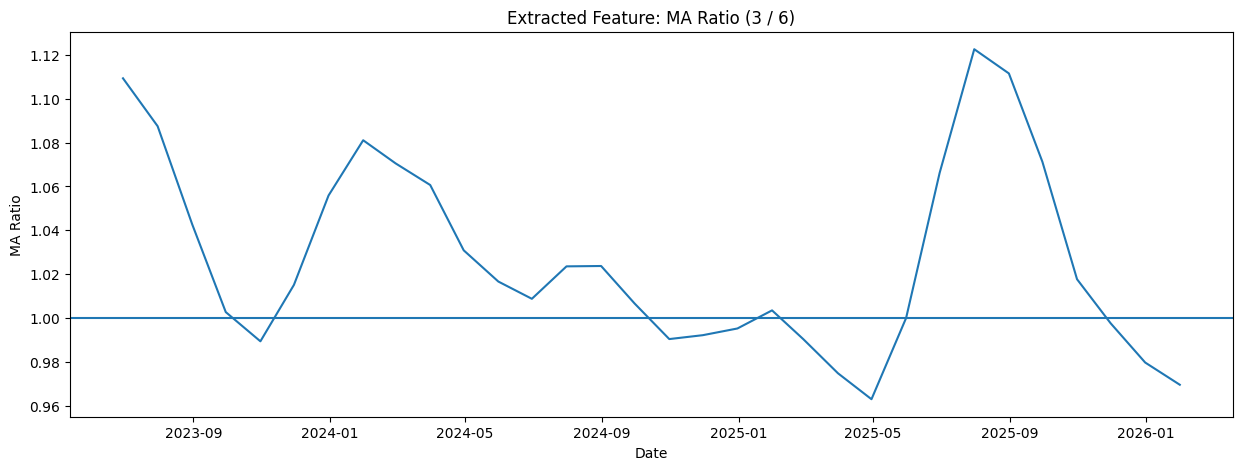

In [36]:
# ---------- 16. DIAGRAMS: show extracted features track key behaviors ----------
plt.figure(figsize=(15, 5))
plt.plot(fx.index, fx["price"])
plt.title("Raw Series: MSFT Price")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(fx.index, fx["vol_6"])
plt.title("Extracted Feature: 6-Month Rolling Volatility")
plt.xlabel("Date"); plt.ylabel("Volatility")
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(fx.index, fx["ma_ratio_3_6"])
plt.title("Extracted Feature: MA Ratio (3 / 6)")
plt.xlabel("Date"); plt.ylabel("MA Ratio")
plt.axhline(1)
plt.show()

In [43]:
# ---------- 17. SIMPLE "DEPLOYMENT" DEMO (predict next return) ----------
import numpy as np
import pandas as pd
import statsmodels.api as sm

fx2 = df_m.copy()

# 1) Flatten tuple/MultiIndex-like columns into plain strings
def flatten_cols(cols):
    flat = []
    for c in cols:
        if isinstance(c, tuple):
            a = str(c[0])
            b = str(c[1]) if len(c) > 1 else ""
            if b == "" or b == "None":
                flat.append(a)
            else:
                flat.append(f"{a}_{b}")
        else:
            flat.append(str(c))
    return flat

if any(isinstance(c, tuple) for c in fx2.columns):
    fx2.columns = flatten_cols(fx2.columns)

print("Flattened columns:", fx2.columns.tolist())

# 2) Detect correct base columns (works whether it's price or price_MSFT)
price_col = "price" if "price" in fx2.columns else ("price_MSFT" if "price_MSFT" in fx2.columns else None)
vol_col   = "Volume" if "Volume" in fx2.columns else ("Volume_MSFT" if "Volume_MSFT" in fx2.columns else None)

if price_col is None:
    raise KeyError(f"No price column found. Columns: {fx2.columns.tolist()}")
if vol_col is None:
    raise KeyError(f"No volume column found. Columns: {fx2.columns.tolist()}")

print("Using price_col:", price_col)
print("Using vol_col:", vol_col)

# 3) Ensure log series
fx2["log_price"] = np.log(fx2[price_col])
fx2["log_ret"] = fx2["log_price"].diff()

# 4) Features
fx2["mom_1"] = fx2[price_col].pct_change(1)
fx2["mom_3"] = fx2[price_col].pct_change(3)
fx2["mom_6"] = fx2[price_col].pct_change(6)

fx2["vol_3"] = fx2["log_ret"].rolling(3).std()
fx2["vol_6"] = fx2["log_ret"].rolling(6).std()

fx2["ma_3"] = fx2[price_col].rolling(3).mean()
fx2["ma_6"] = fx2[price_col].rolling(6).mean()
fx2["ma_ratio_3_6"] = fx2["ma_3"] / fx2["ma_6"]

fx2["vol_chg"] = fx2[vol_col].pct_change()

feature_cols = ["mom_1", "mom_3", "mom_6", "vol_3", "vol_6", "ma_ratio_3_6", "vol_chg"]

# 5) Target
fx2["y_next"] = fx2["log_ret"].shift(-1)

# 6) Drop NA rows safely
data = fx2.dropna(subset=feature_cols + ["y_next"]).copy()
print("Rows used for regression:", data.shape[0])

X = sm.add_constant(data[feature_cols])
y = data["y_next"]

model_feat = sm.OLS(y, X).fit()
print(model_feat.summary())


Flattened columns: ['price_MSFT', 'Volume_MSFT', 'log_price', 'log_ret']
Using price_col: price_MSFT
Using vol_col: Volume_MSFT
Rows used for regression: 30
                            OLS Regression Results                            
Dep. Variable:                 y_next   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                 -0.078
Method:                 Least Squares   F-statistic:                    0.6991
Date:                Sat, 03 Jan 2026   Prob (F-statistic):              0.673
Time:                        11:50:34   Log-Likelihood:                 46.628
No. Observations:                  30   AIC:                            -77.26
Df Residuals:                      22   BIC:                            -66.05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>